In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import yaml
from celldreamer.paths import ROOT
from celldreamer.estimator.celldreamer_estimator import CellDreamerEstimator
from celldreamer.paths import DATA_DIR
from celldreamer.data.utils import Args

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import ModelSummary

In [2]:
cd $ROOT

/nfs/homedirs/pala/celldreamer


Load configuration 

In [3]:
config = yaml.safe_load(open(ROOT / "configs/scrnaseq/config_ddpm.yaml", 
                            "rb"))
args_pert = Args(config["args"]) 

Initialize estimator 

In [4]:
estimator = CellDreamerEstimator(args_pert)

Create the training folders...
Initialize data module...


/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
F

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initialize feature embeddings...
Initialize model...


In [5]:
estimator.generative_model

ConditionalGaussianDDPM(
  (denoising_model): MLPTimeStep(
    (net): Sequential(
      (0): MLPTimeEmbedCond(
        (time_embed_net): Sequential(
          (0): Linear(in_features=100, out_features=32, bias=True)
          (1): SELU()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (net): Sequential(
          (0): Linear(in_features=50, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SELU()
        )
        (out_layer): Linear(in_features=32, out_features=32, bias=True)
      )
      (1): MLPTimeEmbedCond(
        (time_embed_net): Sequential(
          (0): Linear(in_features=100, out_features=32, bias=True)
          (1): SELU()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (net): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affin

Train model

In [6]:
estimator.train()

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/ ...
  rank_zero_warn(
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /nfs/students/pala/celldreamer/try_experiment_pbmc/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type        | Params
------------------------------------------------
0 | denoising_model | MLPTimeStep | 25.4 K
1 | mse             | MSELoss     | 0     
------------------------------------------------
25.4 K    Trainable

Sanity Checking: 0it [00:00, ?it/s]

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
estimator.generative_model = estimator.generative_model.to("cuda")
estimator.generative_model.denoising_model = estimator.generative_model.denoising_model.to("cuda")

In [23]:
# ckpt = torch.load("/nfs/students/pala/celldreamer/try_experiment_pbmc/checkpoints/epoch_270.ckpt")
# estimator.generative_model.load_state_dict(ckpt["state_dict"])

**Generate**

In [9]:
T = estimator.generative_model.T
T

In [10]:
vec = torch.randn(10, 50).to("cuda")
t1 = 1000*torch.ones(10).to("cuda")
t2 = 1*torch.ones(10).to("cuda")

In [11]:
estimator.generative_model.denoising_model(vec, t1, None)

In [12]:
estimator.generative_model.denoising_model(vec.to('cuda'), t2.to('cuda'), None)

**Check timestep embedding**

In [23]:
# X_gen = estimator.generative_model.sample(batch_size=1000,
#                                              y=None, 
#                                    `          return_all_timesteps=False,
#                                              clip_denoised=True)

X_gen= estimator.generative_model.ddim_sample(batch_size=1000, 
                      y=None, 
                      return_all_timesteps = False, 
                      ddim_sampling_eta=0)

100%|██████████| 1000/1000 [00:01<00:00, 573.19it/s]


In [24]:
X_gen

tensor([[ 1.0000, -0.9962, -0.6670,  ..., -0.2723, -0.7744,  0.0205],
        [ 1.0000,  0.9971, -0.2470,  ..., -0.7252,  0.5242, -0.3210],
        [-0.9808,  1.0000,  0.1110,  ...,  0.1079,  0.5769, -0.2134],
        ...,
        [ 1.0000,  0.9608, -0.2012,  ...,  0.7645, -0.3757,  0.2209],
        [ 0.9975,  0.9823,  0.1114,  ..., -0.9039, -0.2201, -0.2694],
        [ 1.0000,  0.9565, -0.2447,  ..., -0.2309, -0.6403, -0.3717]],
       device='cuda:0')

**Plot generated**

In [25]:
adata_tmp = sc.AnnData(X=X_gen.detach().cpu().numpy())
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


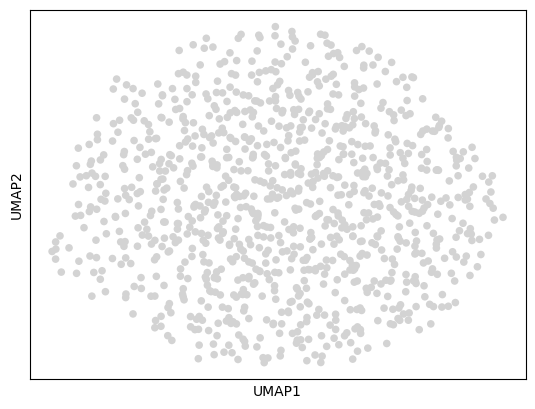

In [26]:
sc.pl.umap(adata_tmp)

In [27]:
d = []

for batch in estimator.datamodule.train_dataloader:
    d.append(batch["X"])
    
d = torch.cat(d, dim=0)
# d = torch.clip(d, -3,3)

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
adata = sc.AnnData(X = np.concatenate([X_gen.detach().cpu().numpy(), d.cpu().numpy()]),
                   obs = pd.DataFrame({"type":["gen"]*len(X_gen)+["real"]*len(d)}))

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


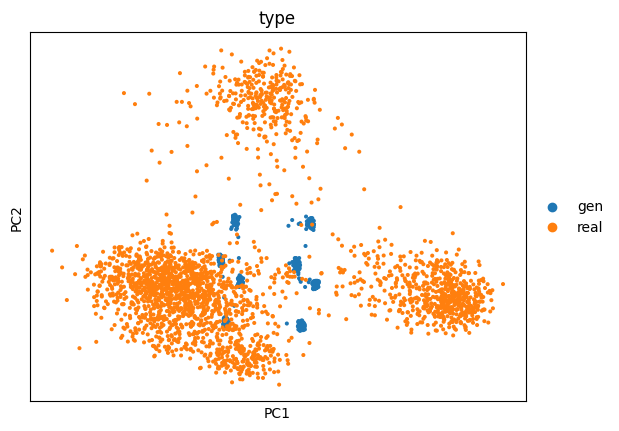

In [30]:
sc.pl.pca(adata, color="type")

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


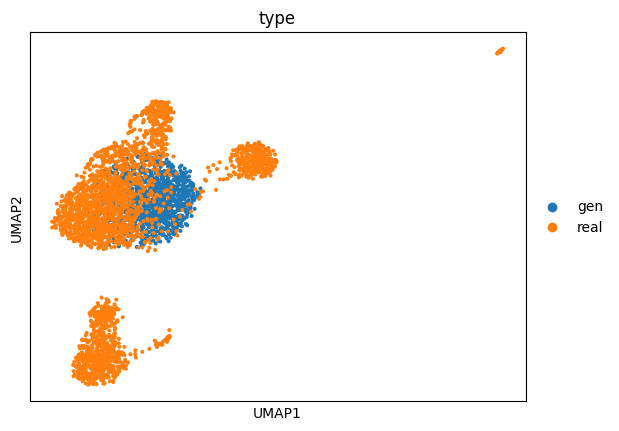

In [31]:
sc.pl.umap(adata, color="type")

In [22]:
d.mean()

tensor(0.0812)

In [23]:
X_gen.mean()

tensor(-0.0134, device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
d.max()

tensor(1.)

In [25]:
d.max()

tensor(1.)

In [26]:
d.min()

tensor(-1.)

In [27]:
d.mean()

tensor(0.0812)

In [28]:
d.min()

tensor(-1.)

In [29]:
# d = 2 * (d - d.min(1).values.unsqueeze(-1)) / (d.max(1).values.unsqueeze(-1) - d.min(1).values.unsqueeze(-1)) - 1

In [30]:
# d = (d - d.min(1).values.unsqueeze(-1)) / (d.max(1).values.unsqueeze(-1) - d.min(1).values.unsqueeze(-1)) 

In [34]:
# d